In [4]:
import numpy as np
import pandas as pd
import pickle
import os
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_digits

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止数值溢出
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    N = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / N  # 加上 1e-8 防止 log(0)
    return loss

In [5]:
# 定义 unpickle 函数
def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

# 加载 CIFAR-10 数据集
def load_cifar10_from_local(data_dir):

    # 加载训练数据
    X_train, y_train = [], []
    for i in range(1, 6):  # CIFAR-10 有 5 个训练 batch
        file_path = os.path.join(data_dir, f'data_batch_{i}')
        data = unpickle(file_path)
        X_train.append(data[b'data'])       # 图像数据
        y_train.extend(data[b'labels'])    # 标签

    # 合并训练数据
    X_train = np.vstack(X_train)           # (50000, 3072)
    y_train = np.array(y_train)            # (50000,)

    # 加载测试数据
    test_file_path = os.path.join(data_dir, 'test_batch')
    test_data = unpickle(test_file_path)
    X_test = test_data[b'data']            # (10000, 3072)
    y_test = np.array(test_data[b'labels'])  # (10000,)

    # 归一化到 [0, 1]
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    # 展平图像
    X_train = X_train.reshape(X_train.shape[0], -1)  # (50000, 3072)
    X_test = X_test.reshape(X_test.shape[0], -1)     # (10000, 3072)

    # 将标签转换为 one-hot 编码
    encoder = OneHotEncoder(sparse_output=False)  
    y_train = encoder.fit_transform(y_train.reshape(-1, 1))  # (50000, 10)
    y_test = encoder.transform(y_test.reshape(-1, 1))        # (10000, 10)

    # 划分训练集和验证集
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.1, random_state=42
    )

    return X_train, y_train, X_val, y_val, X_test, y_test

# 指定 CIFAR-10 数据集的本地路径
data_dir = r"E:\NNandDL\first\dataset\cifar-10-python\cifar-10-batches-py"

# 加载数据
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10_from_local(data_dir)

# 打印数据形状以确认加载成功
print("X_train shape:", X_train.shape)  # 应为 (45000, 3072)
print("y_train shape:", y_train.shape)  # 应为 (45000, 10)
print("X_val shape:", X_val.shape)      # 应为 (5000, 3072)
print("y_val shape:", y_val.shape)      # 应为 (5000, 10)
print("X_test shape:", X_test.shape)    # 应为 (10000, 3072)
print("y_test shape:", y_test.shape)    # 应为 (10000, 10)

X_train shape: (45000, 3072)
y_train shape: (45000, 10)
X_val shape: (5000, 3072)
y_val shape: (5000, 10)
X_test shape: (10000, 3072)
y_test shape: (10000, 10)


In [6]:
# 超参数范围
learning_rates = [0.05, 0.1]
hidden_sizes_list = [[256], [512]]
l2_lambdas = [0, 0.001, 0.01]
initializers = ["random"]
optimizers = ["sgd"]
lr_decay_types = ["exponential", "linear", "constant", ]
decay_rates = [0.90]
decay_steps_list = [10]

In [7]:
import numpy as np
import pickle  # 用于保存和加载模型

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    N = y_true.shape[0]
    log_likelihood = -np.log(y_pred[np.arange(N), np.argmax(y_true, axis=1)] + 1e-8)
    loss = np.sum(log_likelihood) / N
    return loss

class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, initializer="random", optimizer="sgd", learning_rate=0.001):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        
        # 初始化权重和偏置
        sizes = [input_size] + hidden_sizes + [output_size]
        self.weights = []
        self.biases = []
        for i in range(len(sizes) - 1):
            if initializer == "random":
                # 随机初始化
                self.weights.append(np.random.randn(sizes[i], sizes[i + 1]) * 0.01)
            elif initializer == "xavier":
                # Xavier 初始化
                scale = np.sqrt(2 / (sizes[i] + sizes[i + 1]))
                self.weights.append(np.random.randn(sizes[i], sizes[i + 1]) * scale)
            else:
                raise ValueError(f"Unsupported initializer: {initializer}")
            self.biases.append(np.zeros((1, sizes[i + 1])))
        
        # 初始化优化器相关变量
        if optimizer == "momentum":
            self.momentum_weights = [np.zeros_like(w) for w in self.weights]
            self.momentum_biases = [np.zeros_like(b) for b in self.biases]
            self.beta = 0.9  # 动量系数

    def forward(self, X):
        self.layers = [X]
        for i in range(len(self.weights) - 1):
            Z = np.dot(self.layers[-1], self.weights[i]) + self.biases[i]
            A = relu(Z)
            self.layers.append(A)
        Z = np.dot(self.layers[-1], self.weights[-1]) + self.biases[-1]
        Y_pred = softmax(Z)
        self.layers.append(Y_pred)
        return Y_pred

    def backward(self, X, y_true, learning_rate, l2_lambda):
        N = X.shape[0]
        layers = self.layers
        dA = layers[-1] - y_true
        dA /= N

        for i in reversed(range(len(self.weights))):
            dZ = dA * (layers[i + 1] > 0)  # ReLU 激活函数的导数
            dW = np.dot(layers[i].T, dZ)
            db = np.sum(dZ, axis=0, keepdims=True)
            dA = np.dot(dZ, self.weights[i].T)

            # 添加 L2 正则化
            dW += l2_lambda * self.weights[i]

            # 根据优化器更新参数
            if self.optimizer == "sgd":
                self.weights[i] -= learning_rate * dW
                self.biases[i] -= learning_rate * db
            elif self.optimizer == "momentum":
                self.momentum_weights[i] = self.beta * self.momentum_weights[i] + (1 - self.beta) * dW
                self.momentum_biases[i] = self.beta * self.momentum_biases[i] + (1 - self.beta) * db
                self.weights[i] -= learning_rate * self.momentum_weights[i]
                self.biases[i] -= learning_rate * self.momentum_biases[i]

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, initial_lr, l2_lambda, lr_decay_type="constant", decay_rate=0.96, decay_steps=10, save_path=None):
        train_losses, val_losses, val_accuracies = [], [], []
        best_val_loss = float('inf')
        best_weights = None
        best_biases = None

        for epoch in range(epochs):
            # 根据学习率下降策略调整学习率
            if lr_decay_type == "exponential":
                learning_rate = initial_lr * (decay_rate ** (epoch / decay_steps))
            elif lr_decay_type == "linear":
                learning_rate = initial_lr * (1 - epoch / epochs)
            elif lr_decay_type == "constant":
                learning_rate = initial_lr
            else:
                raise ValueError(f"Unsupported learning rate schedule: {lr_decay_type}")

            # 打乱数据
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            # 小批量梯度下降
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]
                self.forward(X_batch)
                self.backward(X_batch, y_batch, learning_rate, l2_lambda)

            # 计算训练和验证指标
            train_loss = cross_entropy_loss(self.forward(X_train), y_train)
            val_loss = cross_entropy_loss(self.forward(X_val), y_val)
            val_accuracy = np.mean(np.argmax(self.forward(X_val), axis=1) == np.argmax(y_val, axis=1))

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(f"Epoch {epoch+1}/{epochs}, Learning Rate: {learning_rate:.6f}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

            # 保存最优模型权重
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_weights = [w.copy() for w in self.weights]
                best_biases = [b.copy() for b in self.biases]
                if save_path:
                    self.save_model(save_path)  # 保存最优模型到指定路径

        # 加载最优模型权重
        self.weights = best_weights
        self.biases = best_biases

        return train_losses, val_losses, val_accuracies

    def evaluate(self, X_test, y_test):
        y_pred = self.forward(X_test)
        accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))
        return accuracy

    def save_model(self, file_path):
        """将模型的权重和偏置保存到本地"""
        model_data = {
            'weights': self.weights,
            'biases': self.biases
        }
        with open(file_path, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {file_path}")

    def load_model(self, file_path):
        """从本地文件加载模型的权重和偏置"""
        try:
            with open(file_path, 'rb') as f:
                model_data = pickle.load(f)
            self.weights = model_data['weights']
            self.biases = model_data['biases']
            print(f"Model loaded from {file_path}")
        except FileNotFoundError:
            print(f"Error: File {file_path} not found.")
        except Exception as e:
            print(f"Error loading model: {e}")

In [31]:
import itertools
import pandas as pd

# 存储结果
results = []

# 遍历所有超参数组合
for lr, hidden_sizes, l2_lambda, initializer, optimizer, lr_decay_type, decay_rate, decay_steps in itertools.product(
    learning_rates, hidden_sizes_list, l2_lambdas, initializers, optimizers, lr_decay_types, decay_rates, decay_steps_list
):
    print(f"Training with lr={lr}, hidden_sizes={hidden_sizes}, l2_lambda={l2_lambda}, initializer={initializer}, "
          f"optimizer={optimizer}, lr_decay_type={lr_decay_type}, decay_rate={decay_rate}, decay_steps={decay_steps}")
    
    # 初始化模型
    model = NeuralNetwork(input_size=3072, hidden_sizes=hidden_sizes, output_size=10,
                          initializer=initializer, optimizer=optimizer, learning_rate=lr)
    
    # 训练模型（不再传递 save_path 参数）
    train_losses, val_losses, val_accuracies = model.train(
        X_train, y_train, X_val, y_val,
        epochs=40, batch_size=64, initial_lr=lr, l2_lambda=l2_lambda,
        lr_decay_type=lr_decay_type, decay_rate=decay_rate, decay_steps=decay_steps
    )
    
    # 测试模型
    test_accuracy = model.evaluate(X_test, y_test)
    
    # 记录结果
    results.append({
        "learning_rate": lr,
        "hidden_sizes": hidden_sizes,
        "l2_lambda": l2_lambda,
        "initializer": initializer,
        "optimizer": optimizer,
        "lr_decay_type": lr_decay_type,
        "decay_rate": decay_rate,
        "decay_steps": decay_steps,
        "val_accuracy": val_accuracies[-1],  # 最后一个 epoch 的验证集准确率
        "test_accuracy": test_accuracy,      # 测试集的准确率
        "model_weights": [w.copy() for w in model.weights],  # 保存模型权重
        "model_biases": [b.copy() for b in model.biases]     # 保存模型偏置
    })
    
    print(f"Test Accuracy: {test_accuracy:.4f}\n")

# 将结果转换为 DataFrame
results_df = pd.DataFrame(results)

# 找出测试集上准确率最高的模型
best_result = results_df.loc[results_df['test_accuracy'].idxmax()]
print("\nBest Hyperparameters:")
print(best_result)

# 保存测试集上准确率最高的模型
best_model = NeuralNetwork(input_size=3072, hidden_sizes=best_result["hidden_sizes"], output_size=10,
                           initializer=best_result["initializer"], optimizer=best_result["optimizer"],
                           learning_rate=best_result["learning_rate"])
best_model.weights = best_result["model_weights"]
best_model.biases = best_result["model_biases"]

# 定义保存路径
best_model_path = "best_model_test_accuracy.pkl"
best_model.save_model(best_model_path)
print(f"\nBest model saved to {best_model_path}")

# 将结果保存为 CSV 文件
results_df.to_csv("hyperparameter_search_results.csv", index=False)
print("Results saved to 'hyperparameter_search_results.csv'")

Training with lr=0.05, hidden_sizes=[256], l2_lambda=0, initializer=random, optimizer=sgd, lr_decay_type=exponential, decay_rate=0.9, decay_steps=10
Epoch 1/40, Learning Rate: 0.050000, Train Loss: 2.0191, Val Loss: 2.0389, Val Accuracy: 0.2672
Epoch 2/40, Learning Rate: 0.049476, Train Loss: 2.0763, Val Loss: 2.1079, Val Accuracy: 0.2546
Epoch 3/40, Learning Rate: 0.048957, Train Loss: 2.1880, Val Loss: 2.2215, Val Accuracy: 0.2938
Epoch 4/40, Learning Rate: 0.048444, Train Loss: 1.7694, Val Loss: 1.8197, Val Accuracy: 0.3558
Epoch 5/40, Learning Rate: 0.047937, Train Loss: 1.7539, Val Loss: 1.7937, Val Accuracy: 0.3556
Epoch 6/40, Learning Rate: 0.047434, Train Loss: 2.0943, Val Loss: 2.1406, Val Accuracy: 0.3200
Epoch 7/40, Learning Rate: 0.046937, Train Loss: 2.0800, Val Loss: 2.1422, Val Accuracy: 0.2934
Epoch 8/40, Learning Rate: 0.046445, Train Loss: 2.6355, Val Loss: 2.7083, Val Accuracy: 0.2656
Epoch 9/40, Learning Rate: 0.045958, Train Loss: 1.9291, Val Loss: 2.0313, Val Accu

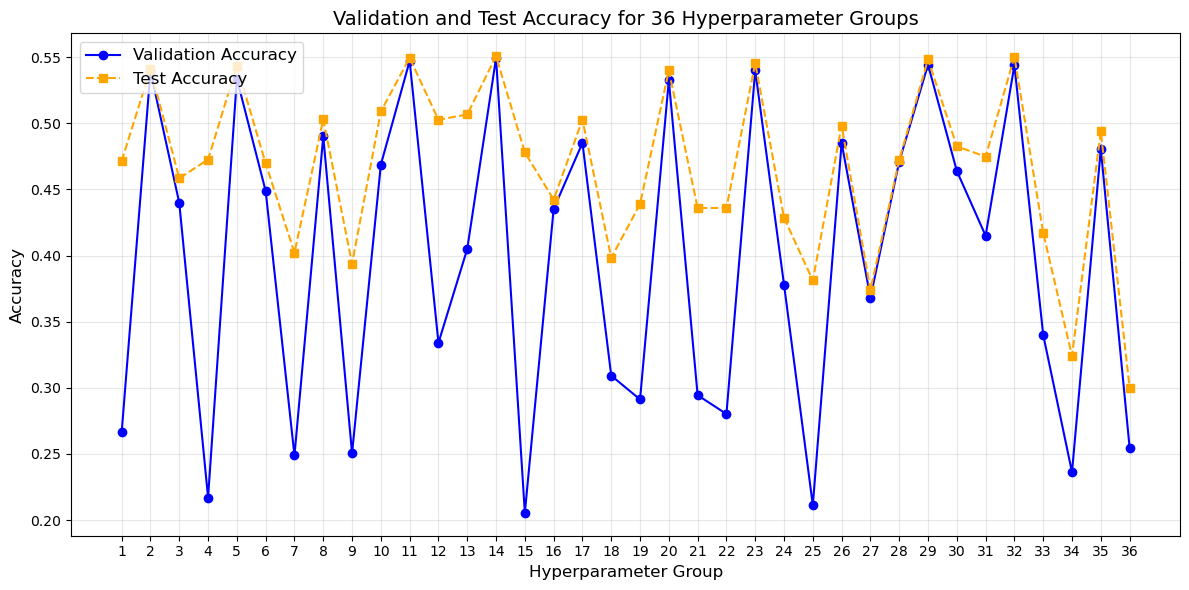

In [32]:
import matplotlib.pyplot as plt

# 提取超参数组合编号（假设 CSV 文件中没有单独的编号列）
results_df['param_group'] = results_df.index + 1  # 按行号生成编号

# 提取 val_accuracy 和 test_accuracy 数据
param_groups = results_df['param_group']
val_accuracies = results_df['val_accuracy']
test_accuracies = results_df['test_accuracy']

# 绘制图表
plt.figure(figsize=(12, 6))

# 绘制验证集准确率曲线
plt.plot(param_groups, val_accuracies, marker='o', linestyle='-', color='blue', label='Validation Accuracy')

# 绘制测试集准确率曲线
plt.plot(param_groups, test_accuracies, marker='s', linestyle='--', color='orange', label='Test Accuracy')

# 添加标题、标签和图例
plt.title("Validation and Test Accuracy for 36 Hyperparameter Groups", fontsize=14)
plt.xlabel("Hyperparameter Group", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(param_groups)  # 设置 x 轴刻度为超参数组编号
plt.legend(loc="upper left", fontsize=12)
plt.grid(alpha=0.3)

# 显示图表
plt.tight_layout()
plt.show()

#### 模型测试

In [9]:
# 测试模型加载与评估的完整流程

# 1. 创建与原始模型结构完全相同的实例
# 假设原始模型参数如下（需要替换为实际使用的参数）
input_size = 3074       # 根据实际输入维度修改
hidden_sizes = [512]  # 根据实际隐藏层结构修改
output_size = 10        # 根据实际输出类别数修改
initializer = "random"  # 必须与训练时使用的初始化方式一致
optimizer = "sgd"       # 必须与训练时使用的优化器一致

# 创建新模型实例
loaded_model = NeuralNetwork(
    input_size=input_size,
    hidden_sizes=hidden_sizes,
    output_size=output_size,
    initializer=initializer,
    optimizer=optimizer
)

# 2. 加载保存的模型权重
best_model_path = "best_model_test_accuracy.pkl"
try:
    loaded_model.load_model(best_model_path)
    print("模型加载成功！")
except Exception as e:
    print(f"模型加载失败: {str(e)}")
    exit()

# 4. 执行评估
try:
    test_accuracy = loaded_model.evaluate(X_test, y_test)
    print(f"\n测试集准确率: {test_accuracy:.4f}")
    
    # 可选：查看前5个样本的预测结果
    sample_pred = loaded_model.forward(X_test[:5])
    print("\n预测样例：")
    print("预测标签:", np.argmax(sample_pred, axis=1))
    print("真实标签:", np.argmax(y_test[:5], axis=1))
except Exception as e:
    print(f"评估过程中发生错误: {str(e)}")

Model loaded from best_model_test_accuracy.pkl
模型加载成功！

测试集准确率: 0.5508

预测样例：
预测标签: [3 8 0 8 4]
真实标签: [3 8 8 0 6]
